# Detecting and Compensating Sensor Faults in a Hydraulic Condition Monitoring System

Sep 2018

By Yujun Zhou

In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import errno
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from functools import reduce
from sklearn.model_selection import GridSearchCV


# suppress Pandas warnings for more readbility
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')


from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


### Data cleaning and validation

### Target condition

The target condition values are cycle-wise annotated in profile.txt (tab-delimited). 
As before, the row number represents the cycle number.

All but number 5 (stable flag) describe degradation processes over time and, thus, their values do not represent distinct categories, but continuous values.

The columns are 

1: Cooler condition / %: 
3: close to total failure 
20: reduced effifiency 
100: full efficiency 

2: Valve condition / %: 
100: optimal switching behavior 
90: small lag 
80: severe lag 
73: close to total failure 

3: Internal pump leakage: 
0: no leakage 
1: weak leakage 
2: severe leakage 

4: Hydraulic accumulator / bar: 
130: optimal pressure 
115: slightly reduced pressure 
100: severely reduced pressure 
90: close to total failure 

5: stable flag: 
0: conditions were stable 
1: static conditions might not have been reached yet

In [2]:
# Load in the target variables as a Pandas DataFrame
names = ['cooler_condition', 'valve_condition', 'pump_leak', 'hydraulic_accumulator', 'stable_flag']

condition = pd.read_csv('target/profile.txt',delim_whitespace=True,header=None,names =names)

# Preview the first few lines
condition.head()

,cooler_condition,valve_condition,pump_leak,hydraulic_accumulator,stable_flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [3]:
# check for irregular values and there was none
for i in enumerate(list(names)):
    print(pd.unique(condition[i[1]]))

[  3  20 100]
[100  73  80  90]
[0 2 1]
[130 115 100  90]
[1 0]


Visualization of the target variables

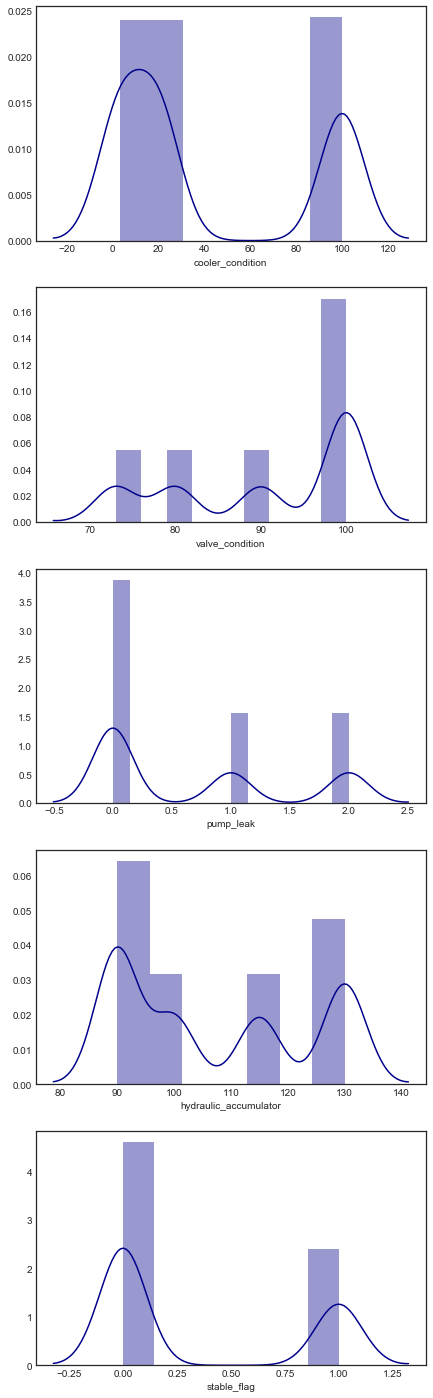

In [4]:
# Construct 5 subplots for the 5 target variables    
figure,(ax1, ax2,ax3,ax4,ax5) = plt.subplots(figsize=(7, 25 ), 
                       nrows=condition.shape[1], ncols=1,sharex = False)
# 
sns.distplot(condition[names[0]], hist=True, color = 'darkblue',ax=ax1)
sns.distplot(condition[names[1]], hist=True,color = 'darkblue',ax=ax2)
sns.distplot(condition[names[2]], hist=True, color = 'darkblue',ax=ax3)
sns.distplot(condition[names[3]], hist=True,color = 'darkblue',ax=ax4)
sns.distplot(condition[names[4]], hist=True, color = 'darkblue',ax=ax5)

### Load the feature time series data 

In [5]:
# import all the feature variables at once
path = 'features/*.txt'
# find all the txt files in the path 
files = glob.glob(path)
# use a dict to save all the variables 
features = {}

for name in files:
    try:
        with open(name) as f:
            # read in the data 
            temp_df = pd.read_csv(name,delim_whitespace=True,header=None)
            # make the row names cycle as a variable
            temp_df.index.name = 'cycle'
            temp_df.reset_index(inplace=True)
            # transpose the data 
            temp_df_transposed= temp_df.T
            # make the seconds a variable, call it "time”
            temp_df_transposed.index.name = 'time'
            temp_df_transposed.reset_index(inplace=True)
            # add a prefix cycle in the column names to help with pivoting data (from wide to long)
            string = ' cycle'.join(str(e) for e in list(temp_df_transposed.columns))
            temp_df_transposed.columns = string.split(" ")
            # From wide to long to help with joining all the variables 
            temp_df_long = pd.wide_to_long(temp_df_transposed.iloc[1:,:],stubnames='cycle', i=['time'], j='c')
            temp_df_long.reset_index(inplace=True)
            # save each data variable in the long format into separate data frames in the dictionary called "features"
            # but exclude path and txt in the names
            features[name[9:-4]] = temp_df_long
                        
           
    
    # prevent a possible error
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise
            

In [6]:
# rename the columns of the variables 
keylist = list(features.keys())

for key in keylist:
    features[key].columns=['seconds','cycle',key]

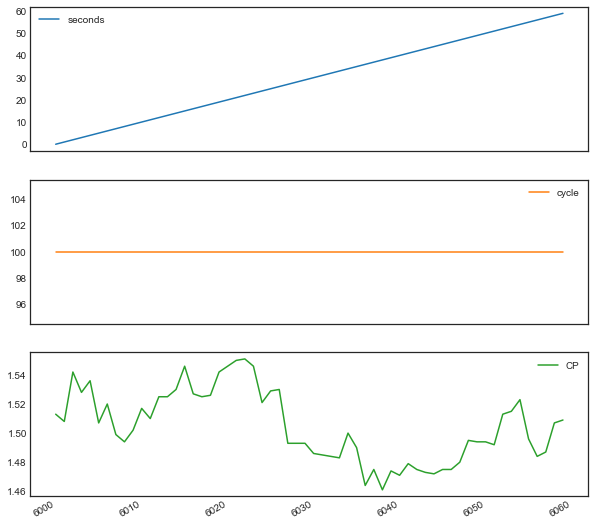

In [7]:
# show an example figure of sensor changes in 60 seconds
features['CP'][features['CP']['cycle']==100].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

### Data Description

#### Target variables chosen: Valve condition

Valve condition %:

100: optimal switching behavior

90: small lag

80: severe lag 

73: close to total failure

From a simple visualization of the 5 different target variables from above, they all look similar and they essentially describes the same thing: degradation processes over time, according to the data description. 

I choose the valve condition variable on the grounds that it relatively evenly distributed, among the other target variables. But there are no reasons quantitatively or qualitatively to suggest the specialty of this target variable. In other words, the prediction algorithm described in this report should apply well on the other target variables as well. 

For the valve condition variable, it contains 2205 cycles, at a mean of 90.69. The median of the sample is 100, meaning more than half of the cycles, the valve is in optimal condition. 

In [8]:
condition['valve_condition'].describe()

count    2205.000000
mean       90.693878
std        10.681802
min        73.000000
25%        80.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: valve_condition, dtype: float64

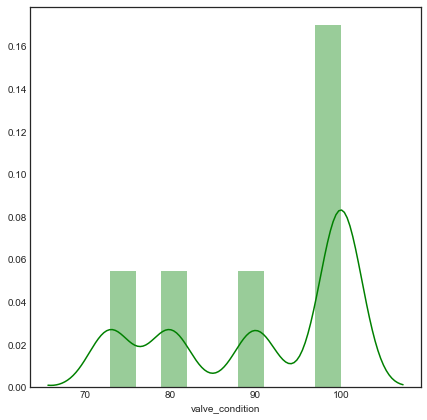

In [9]:
figure,ax = plt.subplots(figsize=(7, 7), sharex = False)
sns.distplot(condition['valve_condition'], hist=True,color = 'green',ax=ax)


#### Attribute information of sensors 

The data desciption of the is a bit tricky. The original "Deteching and compensating sensor faults in a hydraulic conditon monitoring system" paper by Helwig et. al (2015) did not include a section of data of the exact features used. In this report, the original time series data is also extracted using a feature extraction and feature selection to come up with a total number of 2286 features. Below is a description of the original sensor information.


The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a first working and a secondary cooling-filtration circuit connected via the oil tank. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump, and accumulator) is quantitatively varied. 

The data set contains raw process sensor data (i.e., without feature extraction) with the rows representing the cycles and the columns the data points within a cycle. 

The sensors involved are: process sensors measuring pressures (PS 1-6), Volume flows (FS1-2), electrical pump input power (EPS1), temperature (TS1-4) and Vibration (VS1). Three virtual sensors (Cooling efficiency, Cooling power, and Efficiency factor) are derived from the physical sensors.

### Joining features, feature extraction and feature feature selection

In [10]:
# make the dataframes into a list 
dfs= [features['CP'],features['CE'],features['EPS1'],features['FS1'],features['FS2'],features['PS1'],features['PS2'],features['PS3'],
     features['PS4'],features['PS5'],features['PS6'],features['SE'],features['TS1'],features['TS2'],features['TS3'],features['TS4'],
     features['VS1']]  

# joining different features based on seconds and cycle
features_join = reduce(lambda left,right: pd.merge(left,right,on=['seconds','cycle']), dfs)
features_join.head()


,seconds,cycle,CP,CE,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
0,0,0,2.184,47.202,2411.6,8.990,10.179,151.47,125.50,2.305,0.0,9.936,9.818,68.039,35.570,40.961,38.320,30.363,0.604
1,1,0,2.184,47.273,2411.6,0.770,10.174,151.45,125.39,2.305,0.0,9.947,9.823,0.000,35.492,40.949,38.332,30.375,0.605
2,2,0,2.184,47.250,2411.6,0.641,10.151,151.52,125.40,2.336,0.0,9.964,9.844,0.000,35.469,40.965,38.320,30.367,0.611
3,3,0,2.185,47.332,2411.6,0.006,10.149,151.27,125.03,2.578,0.0,9.989,9.861,0.000,35.422,40.922,38.324,30.367,0.603
4,4,0,2.178,47.213,2411.6,0.000,10.172,150.80,124.05,2.977,0.0,9.996,9.877,0.000,35.414,40.879,38.332,30.379,0.608


The critical feature about those cyclical time series is that the fault mechanism produces a specific "fingerprint" in the cyclical sensor data. Taking note of these characteristics is essential. However, we cannot directly apply machine learning methods directly, treating each measurement point as a variable. The high dimensional problem associated with estimating a vast number of parameters would computationally troublesome and likely lead to overfitting. Dimension reduction technique is thereby required. 
Specifically, we need to extract characteristic features from the time series (feature extraction) and select the most relevant features (features selection). Feature extraction is an unsupervised process that only depends on the basic shape of the cycle that is to be represented by the elements. Feature selection is, on the other hand, a supervised process that selects the most relevant features concerning a given classification target to reduce further the number of variables that enter into the models.

The idea and methodology of the approach comes from the following papers:
1. Christ, M., Kempa-Liehr, A.W. and Feindt, M. (2016). Distributed and parallel time series feature extraction for industrial big data applications. ArXiv e-prints: 1610.07717
2. Christ, M., Braun, N., Neuffer, J. and Kempa-Liehr A.W. (2018). Time Series FeatuRe Extraction on basis of Scalable Hypothesis tests (tsfresh -- A Python package). Neurocomputing 307 (2018) 72-77, doi:10.1016/j.neucom.2018.03.067.
3. Schneider, Tizian, Nikolai Helwig, and Andreas Schütze. "Automatic feature extraction and selection for classification of cyclical time series data." tm-Technisches Messen 84.3 (2017): 198-206.


The filtering process consists of three phases which are sketched in the following figure:
1. Feature extraction: calculate relevant features from each cycle.
2. Feature evaluation: evaluate the importance of the different extracted features (using feature significance testing with regard to the target).
3. Feature selection: evaluated  the features on basis of the Benjamini-Yekutieli procedure in order to decide which features to keep




![Illustration of feature_extraction_process ](feature_extraction_process.png "Illustration of feature extraction process")


In this particular case, the characteristics are the shape of each cycle for each sensor. The figure below demonstrates some of these signals that each cycle contains. More precisely, the shape is characterised by measures including: sum over the squared values, the sum over the absolute value of consecutive changes,aggregation autocorrelation,approximate entropy, linear trend, count of values above the mean, etc.
A full list of the features are listed in this link (https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).



![Illustration of characteristics ](tsfresh.png "Illustration of characteristics")


Below, I use the automactic feautre extraction and feautre selection methods using the tsfresh package.

In [11]:
# Automatic feautre extraction using the tsfresh package
extracted_features = extract_features(features_join, column_id="cycle", column_sort="seconds")
# Impute any possible missing values 
impute(extracted_features)

# select the more relevant features with regard to the valve condition.
features_filtered = select_features(extracted_features, condition['valve_condition'])

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [20:41<00:00, 62.09s/it]
 'CE__fft_coefficient__coeff_31__attr_"angle"'
 'CE__fft_coefficient__coeff_31__attr_"imag"' ...
 'VS1__fft_coefficient__coeff_99__attr_"angle"'
 'VS1__fft_coefficient__coeff_99__attr_"imag"'
 'VS1__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.


In [12]:
features_filtered.head()

variable,"SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_2","SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_2","SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_5","SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_20","SE__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""","SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_9__w_20","SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_5","SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_5","SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_2","SE__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_2",...,TS3__kurtosis,"VS1__fft_coefficient__coeff_15__attr_""real""",SE__approximate_entropy__m_2__r_0.1,"TS2__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",SE__time_reversal_asymmetry_statistic__lag_2,SE__time_reversal_asymmetry_statistic__lag_1,"TS3__fft_coefficient__coeff_18__attr_""abs""","TS2__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","TS2__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","TS3__fft_coefficient__coeff_4__attr_""real"""
id,,,,,,,,,,,,,,,,,,,,,
0,-27.596950,-13.394721,-59.610291,123.166684,22.657000,135.049766,-69.146999,-46.560969,-54.220684,-36.146369,...,-0.664441,0.013,0.382694,0.020281,11165.058375,5393.316246,0.232453,0.000738,0.001348,-0.252027
1,-27.240551,-13.303555,-58.749215,122.032900,22.578476,133.938035,-68.757818,-45.434743,-52.707259,-35.191274,...,-0.936856,0.082,0.385361,0.030206,11940.571877,5772.836422,0.459333,0.000493,0.000986,-0.649945
2,-27.528574,-13.415471,-59.241101,123.056925,23.049190,135.024418,-69.120107,-45.970105,-53.493491,-35.732761,...,-0.880197,0.027,0.381953,0.029861,11768.303961,5695.226110,0.631316,0.000505,0.000906,-0.815835
3,-27.745590,-13.483140,-60.282422,124.266575,22.990095,136.312449,-70.051678,-47.000789,-54.430591,-36.246321,...,-0.885105,0.027,0.389467,0.027125,11662.584749,5617.691338,0.772126,0.000507,0.000704,-0.847633
4,-26.654870,-13.170702,-57.431716,120.706247,22.824286,132.684908,-68.333692,-43.582395,-50.148067,-33.524348,...,-1.152877,0.040,0.379202,0.029588,13102.182578,6334.214916,0.531304,0.000556,0.000995,-0.803187


In [17]:
features_filtered.shape

(2205, 2286)

### Outlier and missing value detection 

In this particular case, outliers of the features are in itself likely to be a singal rather than an observation to be excluded. 

In terms of missing values, there are no missing values in the feature data or the target condition data. (Data Descpition mentions "Missing Attribute Values: None."). This information is collaborated by the checks below, showing that there is no missing in both the features or the target data.

In [14]:
# test if any missing values in the features
features_filtered.isnull().any().any()

False

In [15]:
# test if any missing values in the target variables.
condition['valve_condition'].isnull().any().any()

False

### Model Fitting

#### Train and Test split

A random split of the sample with 30% being the test sample and 70% being the training sample. The number of observation is 2205, which is not huge compared to the number of features. I decided not to have a validation set and choose a reltively bigger training set in order to make full use of the information in the data. 

In [16]:
# use a random split of training and testing
X_train, X_test, y_train, y_test = train_test_split(features_filtered,  condition['valve_condition'], test_size=.3,random_state=822)


#### Models chosen: LDA, Random Forest, Gradient Boosting

The modeling strategy about this problem is to deal with the high dimensionality problem. Notably, the number of features is slightly more than the number of observations (2286 features and 2205 cycles). 


In high-dimensional spaces including those problems where the number of features is similar to or slightly exceeds the number of instances, data can more easily be separated linearly and the simplicity of classifiers such a Linear Discriminant Analysis or a Linear SVM might lead to better generalization than is achieved by other classifiers, such as a Quadratic Discriminant Analysis. However, despite hours of trying, training and tuning the propoer kernel and hyperparameters for a linear SVM seems difficult. Following  Helwig et. al (2015), I choose the LDA as a baseline classifier.

Ensembling leaning approaches including bagging and boosting have been used regularly applied to achieve a higher level of accuracy in a high dimensionality problem and avoid overfitting. These approaches combine weak learners, and by majority voting, generate weights for the input training data to make the prediction more accurate. 

I choose a standard bagging algorithm Random Forest and a boosting algorithm Gradient Boosting for this exercise. 


The hyperparameters and kernels are searched via a grid search method with cross-validation, for all of the three models.

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
parameters = {'n_components':np.arange( 1,10, 1 ).tolist()}

clf_lda = GridSearchCV(lda, parameters,cv=6, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')
clf_lda.fit(X_train, y_train)
print(clf_lda.best_params_)


{'n_components': 1}


In [30]:
from sklearn.ensemble import RandomForestClassifier

# Lets build our model and train it all at once
rfc = RandomForestClassifier(random_state =822,n_jobs =4,warm_start = True)

parameters = {'max_depth':np.arange( 2,12, 1 ).tolist(), 'min_samples_leaf':np.arange( 1,5, 1 ).tolist()}
clf_rfc = GridSearchCV(rfc, parameters,cv=6, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')
clf_rfc.fit(X_train, y_train)
print(clf_rfc.best_params_)
# Fit estimator to scaled training data

{'max_depth': 9, 'min_samples_leaf': 2}


In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# First we construct our gradient boosting model, 
# We specify 500 trees to start, each with a maximum 
# depth of three. We also specify the random_state 
# hyperparameter to ensure reproduceability.
gbtc = GradientBoostingClassifier(n_estimators=500, random_state=822)
parameters = {'max_depth':np.arange( 2,6,1 ).tolist()}
clf_gbtc = GridSearchCV(gbtc, parameters,cv=6, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')
clf_gbtc.fit(X_train, y_train)
print(clf_gbtc.best_params_)

{'max_depth': 5}


### Results comparison and visualization of prediction

Define a function for plotting the confusion matrix to help with visualization

In [35]:
def confusion(test, predict, names, bins=4, title='Confusion Matrix'):

    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(test, predict, bins)

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    
    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")    
    hm.axes.set_title(title, fontsize=20)
    hm.axes.set_xlabel('Actual', fontsize=18)
    hm.axes.set_ylabel('Predicted', fontsize=18)

    return None

The result metrics are mainly using three measures: 

1. Accuracy. The percent of data that we accurately predict in each category. 


2. Preicision. The number of true positives divided by the number of true positives plus the number of false positives. 


3. Recall. The number of true positives divided by the number of true positives plus the number of false negatives.

Comparing the results of the three algorithms, the baseline LDA has lower overall accuracy at 61.2%. The overall accuracy is between 84% to 87.6% for the later two methods. This performance is very close to the  Helwig et. al (2015), despite a short time frame for feature engineering and parameter tuning. The specific results are shown in terms of tables and confusion matrices below.

We certainly care about the overall accuracy. However, we also care more about in the particular problem about preventing potential system failures at the end where the valve is close to a fault and severe lag. By looking at the reports of all the three methods and the confusion matrices, the accuracy is exceptionally high on the potential hazardous end for Random Forest and Gradient Boosting. The Gradient Boosting results, for example, the predicted results have 0.99 precision, 0.98 recall for the 73 categories; 0.96 precision, 0.99 recall for the 80 class. This should serve well the purpose for detecting a possible faulty signal in sensors.

The underperformance mainly comes from trying to differentiating the 90 and 100 categories,i.e., trying to tell if it is fully functional or it has a small lag. While we would wish to improve on the prediction result on this end, it appears to be a relatively minor problem in the error detection context that this project is concerned about. 







In [42]:
# Compute and display accuracy score

# Make the prediction using the fine-tuned model and compute accuracy
lda_score = 100.0 * clf_lda.score(X_test, y_test)

print(f"LDA classifier prediction accuracy = {lda_score:5.1f}%")
print(classification_report(y_test, clf_lda.predict(X_test)))

LDA classifier prediction accuracy =  61.2%
             precision    recall  f1-score   support

         73       0.92      0.96      0.94       118
         80       0.49      0.68      0.57       111
         90       0.31      0.41      0.35       117
        100       0.73      0.53      0.62       316

avg / total       0.65      0.61      0.62       662



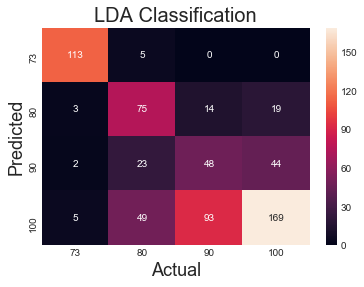

In [43]:
#  confusion matrix plotting for LDA
confusion(y_test, 
             clf_lda.predict(X_test), ["73","80","90","100"], 4, 
             'LDA Classification')

In [38]:
# Compute and display accuracy score for random forest
rfc_score = 100.0 * clf_rfc.score(X_test, y_test)
print(f"Random Forest prediction accuracy = {rfc_score:5.1f}%")
print(classification_report(y_test, clf_rfc.predict(X_test)))

Random Forest prediction accuracy =  84.4%
             precision    recall  f1-score   support

         73       0.99      0.98      0.99       118
         80       0.95      0.97      0.96       111
         90       0.62      0.44      0.52       117
        100       0.82      0.90      0.85       316

avg / total       0.83      0.84      0.84       662



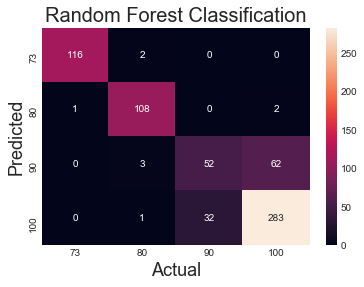

In [39]:
#  confusion matrix plotting for random forest
confusion(y_test, 
             clf_rfc.predict(X_test), ["73","80","90","100"], 4, 
             'Random Forest Classification')

In [40]:
# Compute and display accuracy score for gbtc
gbtc_score = 100.0 * clf_gbtc.score(X_test, y_test)
print(f"Gradient Boosting prediction accuracy = {gbtc_score:5.1f}%")
print(classification_report(y_test, clf_gbtc.predict(X_test)))

Gradient Boosting prediction accuracy =  87.6%
             precision    recall  f1-score   support

         73       0.99      0.98      0.99       118
         80       0.96      0.99      0.97       111
         90       0.72      0.55      0.62       117
        100       0.85      0.92      0.88       316

avg / total       0.87      0.88      0.87       662



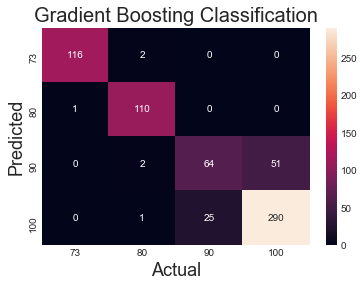

In [41]:
#  confusion matrix plotting for Gradient Boosting Classification
confusion(y_test, 
             clf_gbtc.predict(X_test), ["73","80","90","100"], 4, 
             'Gradient Boosting Classification')

### References


1. Christ, M., Kempa-Liehr, A.W. and Feindt, M. (2016). Distributed and parallel time series feature extraction for industrial big data applications. ArXiv e-prints: 1610.07717

2. Christ, M., Braun, N., Neuffer, J. and Kempa-Liehr A.W. (2018). Time Series FeatuRe Extraction on basis of Scalable Hypothesis tests (tsfresh -- A Python package). Neurocomputing 307 (2018) 72-77, doi:10.1016/j.neucom.2018.03.067.

3. Helwig, N., E. Pignanelli, and A. Schütze. "Detecting and compensating sensor faults in a hydraulic condition monitoring system." Proc. SENSOR. 2015.

4. Schneider, Tizian, Nikolai Helwig, and Andreas Schütze. "Automatic feature extraction and selection for classification of cyclical time series data." tm-Technisches Messen 84.3 (2017): 198-206.